# Validating analytical predictions

In this section we show an example of validating some simple analytical predictions from coalescent theory using simulations. The number of segregating sites is the total number of mutations that occured in the history of the sample (assuming the infinite sites mutation model). Since mutations happen as a Poisson process along the branches of the tree, what we are really interested in is the distribution of the total branch length of the tree. The results in this section are well known classical results from coalescent theory; this section is intended as a demonstration of how one goes about comparing analytical results to simulations.


In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import msprime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.special import binom

The first properties that we are interested in are the mean and the variance of the total branch length of coalescent trees. (Note that, as before, we set ``Ne=1/2`` to convert between msprime's diploid time scaling to the haploid time scaling of these analytical results.)

In [39]:
ns = np.array([5, 10, 15, 20, 25, 30])
num_replicates = 10000
n_col = np.zeros(ns.shape[0] * num_replicates)
T_total_col = np.zeros(ns.shape[0] * num_replicates)
row = 0
for n in ns:
    for ts in msprime.simulate(n, Ne=0.5, num_replicates=num_replicates):
        tree = ts.first()
        n_col[row] = n
        T_total_col[row] = tree.total_branch_length
        row += 1
df = pd.DataFrame({"n": n_col, "T_total": T_total_col})

We first create a array of the six different $n$ values that we wish to simulate, and the create arrays to hold the results of the simulations. Because we are running 10,000 replicates for each sample size, we allocate arrays to hold 60,000 values. This approach of storing the data in arrays is convenient because it allows us to use Pandas dataframes in an idiomatic fashion. After doing this, we then iterate over all of our sample sizes and run 10,000 replicates of each. For each simulation, we simply store the sample size value and the total branch length. Once the simulation is completed, we store the information in a Pandas dataframe, which gives us access to many powerful data analysis tools (including the Seaborn library, which we use for visualisation here).

After we have created our simulation data, we then define our analytical predictions and plot the data.

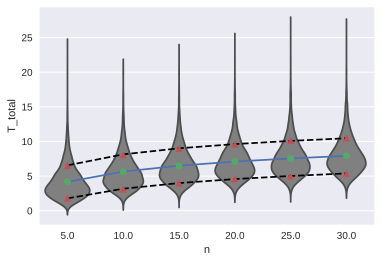

In [40]:
def T_total_mean(n):
    return 2 * np.sum(1 / np.arange(1, n))

def T_total_var(n):
    return 4 * np.sum(1 / np.arange(1, n)**2)

mean_T = np.array([T_total_mean(n) for n in ns])
stddev_T = np.sqrt(np.array([T_total_var(n) for n in ns]))
ax = sns.violinplot(x="n", y="T_total", data=df, color="grey", inner=None)
ax.plot(mean_T, "-");
ax.plot(mean_T - stddev_T, "--", color="black");
ax.plot(mean_T + stddev_T, "--", color="black");
group = df.groupby("n")
mean_sim = group.mean()
stddev_sim = np.sqrt(group.var())
x = np.arange(ns.shape[0])
ax.plot(x, mean_sim, "o")
line, = ax.plot(x, mean_sim - stddev_sim, "^")
ax.plot(x, mean_sim + stddev_sim, "^", color=line.get_color());

This plot shows the simulated distribution of the total branch lengths over replicate simulations (each violin is a distribution for a given sample size). We also show our analytical prediction for the mean and variance of each distrubution (the dashed lines show +/- one standard deviation from the mean). Also shown are the observed means and standard deviations from the simulations, as green circles and red triangles, respectively. We can see that the simulated values match our theoretical predictions for mean and variance very well. We can also see, however, that these one-dimensional summaries of the distrubution capture some essential properties but lose some important aspects of the distribution. 


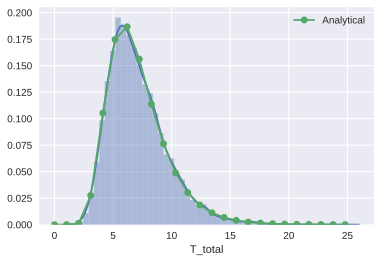

In [46]:
def T_total_density(n, t):
    e_t2 = np.exp(-t / 2)
    return 0.5 * (n - 1) * e_t2 * (1 - e_t2)**(n - 2) 

n = 20
T_total_20 = T_total_col[n_col == n]
ts = np.linspace(0, np.max(T_total_20), 25)
t_densities = np.array([T_total_density(n, t) for t in ts])
sns.distplot(T_total_20)
plt.plot(ts, t_densities, marker="o", label="Analytical")
plt.xlabel("T_total")
plt.legend();


Ideally, we wish to capture the full complexity of the distribution as an analytical value. Here we plot the full distribution for the total tree length with a sample of size 20, along with the empirical prediction. We can see an excellent agreement between smoothed kernel density esimate produced by Seaborn and our analytically computed value.

We cannot directly observe branch lenghts, and so we are usually more interested in mutations when working with data. The mutation process is intimately related to the distribution of branch lengths, since mutations occur randomly along tree branches. One simple summary of the mutational process is the number of segregating sites, or the  number of sites at which we observe variation. We can obtain this information very easily from simulations simply by specifying a mutation rate parameter. (Note again that we set $N_e=1/2$ and our mutation rate = $\theta / 2$ in order to convert to msprime's time scales.)

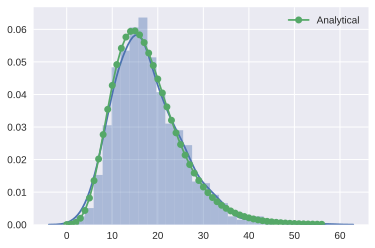

In [47]:
def S_dist(n, theta, k):
    S = 0
    for i in range(2, n + 1):
        S += ((-1)**i * binom(n - 1, i - 1) 
              * (i - 1) / (theta + i - 1) * (theta / (theta + i - 1))**k)
    return S

n = 20
theta = 5
num_replicates = 1000
simulation = np.zeros(num_replicates)
replicates = msprime.simulate(
    n, Ne=0.5, mutation_rate=theta / 2, num_replicates=num_replicates)
for j, ts in enumerate(replicates):
    simulation[j] = ts.num_sites  # number of seg. sites
ks = np.arange(np.max(simulation))
analytical = np.array([S_dist(n, theta, k) for k in ks])
sns.distplot(simulation) 
plt.plot(ks, analytical, marker='o', label="Analytical")
plt.legend();


Here we take 1000 replicate simulations, store the number of infinite sites mutations for each one and then plot this distrubution. We also plot analytical prediction, and see an excellent fit.


## Recombination

In the previous section we saw how to run simulations to generate trees under the assumptions of the single-locus coalescent and compare these with analytical predictions. This assumes that our data is not affected by recombination, which is often unrealistic. Here we show how to compute empirical distrubutions of equivalent quantities, and compare these with classical results from the literature. Since analytical results are not known in general for many quantites under recombination, we limit ourselves to the pairwise case.

In [48]:
theta = 2
num_replicates = 10000
rhos = np.arange(1, 10)
N = rhos.shape[0] * num_replicates
rho_col = np.zeros(N)
s_col = np.zeros(N)
row = 0
for rho in rhos:
    replicates = msprime.simulate(
        sample_size=2, Ne=0.5, mutation_rate=theta / 2, recombination_rate=rho / 2,
        num_replicates=num_replicates)
    for ts in replicates:
        rho_col[row] = rho
        s_col[row] = ts.num_sites
        row += 1
df = pd.DataFrame({"rho": rho_col, "s": s_col})

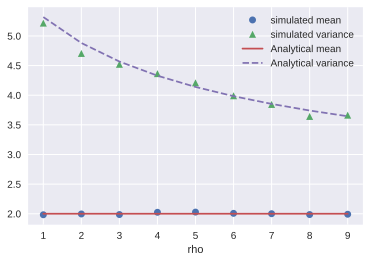

In [49]:
def pairwise_S_mean(theta):
    return theta 

def f2(rho):
    return (rho + 18) / (rho**2 + 13 * rho + 18)

def pairwise_S_var(theta, rho):
    integral = scipy.integrate.quad(lambda x: (rho - x) * f2(x), 0, rho)
    return theta + 2 * theta**2 * integral[0] / rho**2
    

group = df.groupby("rho")
plt.plot(group.mean(), "o", label="simulated mean")
plt.plot(group.var(), "^", label="simulated variance")
plt.plot(rhos, [pairwise_S_mean(theta) for rho in rhos], "-", label="Analytical mean")
plt.plot(rhos, [pairwise_S_var(theta, rho) for rho in rhos], "--", label="Analytical variance")
plt.xlabel("rho")
plt.legend();

Comparing the simulated results to analytical predictions we see excellent agreement. The mean number of segregating sites is not affected by recombination, but recombination does substantially reduce the variance.